In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../data/CC GENERAL.csv')
data.drop(['CUST_ID','TENURE'],axis=1, inplace=True)

In [3]:
print(data.shape)
print('\nFEATURES:\n\n',data.columns)

cols_with_missing = []
for col in data.columns:
    if data[col].isnull().any() or data[col].isna().any():
        cols_with_missing.append(col)


print('\nCOLS WITH MISSING VALUES:')

for col in cols_with_missing:
    print(col, data[col].isna().sum(), 'Valor(es) faltantes')

display(data.head())

(8950, 16)

FEATURES:

 Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'],
      dtype='object')

COLS WITH MISSING VALUES:
CREDIT_LIMIT 1 Valor(es) faltantes
MINIMUM_PAYMENTS 313 Valor(es) faltantes


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  
0   201.802084        139.509787          0.000000  
1  4103.032597       1072.340217          0.222222  
2   622.066742        627.284787          0.000000  
3     0.000000               NaN          0.000000  
4   678.334763        244.791237          0.000000

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputed_missing_values = imputer.fit_transform(data[cols_with_missing])
data[cols_with_missing] = imputed_missing_values

In [5]:
for col in cols_with_missing:
    print(col, data[col].isna().sum(), 'Valor(es) faltantes')

CREDIT_LIMIT 0 Valor(es) faltantes
MINIMUM_PAYMENTS 0 Valor(es) faltantes


# PCA and Normalization pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

seed = 42
np.random.seed(42)
pca_pipe = Pipeline([
   ('scaler', Normalizer()),
   ('PCA', PCA(n_components=2, random_state=seed))
])

In [7]:
pca_values = pca_pipe.fit_transform(data)

# getting x and y values
projection = pd.DataFrame(columns=['X','Y'], data=pca_values)
projection.head()

X         Y
0 -0.315292 -0.041621
1  0.318365 -0.161004
2 -0.207151 -0.180748
3 -0.291842 -0.113087
4  0.142324 -0.090895

# Finding the optimal number of clusters

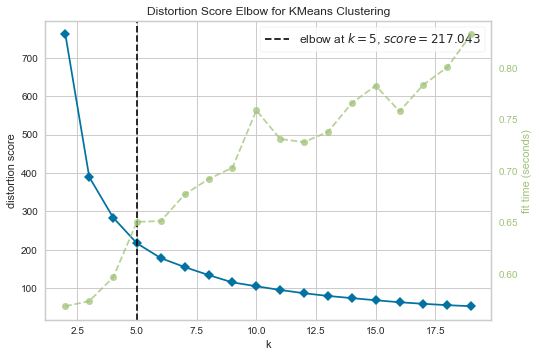

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(projection)
visualizer.show()

In [9]:
kmeans_pca = KMeans(n_clusters=5, verbose=False, random_state=seed, n_init=10, max_iter=300)
kmeans_pca.fit(projection)
data['CLUSTER_PCA'] = kmeans_pca.predict(projection)

In [10]:
data['CLUSTER_PCA'].unique()

array([2, 1, 4, 3, 0])

# Plotting Clusters

In [11]:
import plotly.express as px
# plot the pca projection with the cluster labels
fig = px.scatter(projection, x='X', y='Y', color=data['CLUSTER_PCA'])
fig.show()

In [12]:
explainability = pca_pipe[1].explained_variance_ratio_.sum()
print(f"o cluster está explicando {explainability * 100:.2f}% dos dados")

o cluster está explicando 61.28% dos dados


# Silhouette score

In [13]:
from sklearn import metrics
labels = kmeans_pca.labels_
silhouette = metrics.silhouette_score(projection, labels, metric='euclidean')

- a metrica de avaliacao do modelo eh a silhueta.
- a silhueta eh uma medida de quao similar um ponto eh ao seu proprio cluster (coerencia) em relacao aos outros clusters (separacao).
- Um valor mais próximo de 1 indica clusters mais separados uns dos outros.

# Indice Davies-Bouldin

- O indice Davies-Bouldin eh uma medida de quao bem os clusters sao separados uns dos outros.
- O indice eh calculado como a media das distancias entre os clusters, dividido pela maior distancia entre os centroides dos clusters.
- Um valor mais baixo indica clusters mais separados uns dos outros.

## Formula

$$DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{R_i + R_j}{d(C_i, C_j)} \right)$$

In [14]:
dbs = metrics.davies_bouldin_score(projection, labels)

# Indice Calinski-Harabasz

- O indice Calinski-Harabasz eh uma medida de quao bem os clusters sao separados uns dos outros.
- O indice eh calculado como a razao entre a dispersao intra-cluster e a dispersao inter-cluster.
- Um valor mais alto indica clusters mais separados uns dos outros.

## Formula

$$CH = \frac{tr(B_k)}{tr(W_k)} *\frac{N_e - k}{k - 1}$$

In [15]:
chs = metrics.calinski_harabasz_score(projection, labels)
chs

11787.207633137841

# Validação relativa

- A validação relativa é um modo de avaliar a qualidade de um agrupamento, comparando-o com um agrupamento de referência.

In [16]:
def clustering_algorithm(n_clusters, dataset):
    kmeans = KMeans(n_clusters=n_clusters, verbose=False, random_state=seed, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(dataset)

    s = metrics.silhouette_score(dataset, labels, metric='euclidean')
    db = metrics.davies_bouldin_score(dataset, labels)
    ch = metrics.calinski_harabasz_score(dataset, labels)

    kmeans.fit(dataset)
    return s, dbs, ch

In [17]:
for i in range(2,21):
    s, db, ch = clustering_algorithm(i, projection)
    print(f'clusters: {i} - silhouette: {s:.2f} - dbs: {db:.2f} - ch: {ch:.2f}')

clusters: 2 - silhouette: 0.45 - dbs: 0.77 - ch: 7071.58
clusters: 3 - silhouette: 0.51 - dbs: 0.77 - ch: 11155.19
clusters: 4 - silhouette: 0.49 - dbs: 0.77 - ch: 11299.90
clusters: 5 - silhouette: 0.46 - dbs: 0.77 - ch: 11787.21
clusters: 6 - silhouette: 0.46 - dbs: 0.77 - ch: 11847.05
clusters: 7 - silhouette: 0.44 - dbs: 0.77 - ch: 11569.63
clusters: 8 - silhouette: 0.42 - dbs: 0.77 - ch: 11634.86
clusters: 9 - silhouette: 0.44 - dbs: 0.77 - ch: 12049.47
clusters: 10 - silhouette: 0.43 - dbs: 0.77 - ch: 11820.79
clusters: 11 - silhouette: 0.38 - dbs: 0.77 - ch: 11802.02
clusters: 12 - silhouette: 0.39 - dbs: 0.77 - ch: 11845.99
clusters: 13 - silhouette: 0.40 - dbs: 0.77 - ch: 11881.28
clusters: 14 - silhouette: 0.40 - dbs: 0.77 - ch: 11854.05
clusters: 15 - silhouette: 0.40 - dbs: 0.77 - ch: 11931.21
clusters: 16 - silhouette: 0.39 - dbs: 0.77 - ch: 12093.72
clusters: 17 - silhouette: 0.39 - dbs: 0.77 - ch: 11981.13
clusters: 18 - silhouette: 0.40 - dbs: 0.77 - ch: 12134.37
cluste

Comprarando os cluster com um conjunto aleatorio de dados

- O conjunto de dados aleatorio eh gerado com a mesma quantidade de clusters e com a mesma quantidade de dados que o conjunto de dados original.

- Com essa validação, podemos saber se o nosso conjunto de dados faz ou nao sentido ser clusterizado.

In [18]:
random_data = np.random.rand(data.count()[0], data.drop('CLUSTER_PCA',axis=1).shape[1])

In [19]:
pd.DataFrame(random_data).head(2)

0         1         2         3         4         5         6   \
0  0.598883  0.274412  0.400030  0.778339  0.941215  0.861880  0.564284   
1  0.148060  0.098685  0.579805  0.627864  0.365228  0.535413  0.788400   

         7         8         9         10        11        12        13  \
0  0.410293  0.332957  0.124957  0.106551  0.688358  0.259794  0.254662   
1  0.818104  0.957912  0.824268  0.564841  0.179657  0.099764  0.054512   

         14        15  
0  0.998195  0.187926  
1  0.666526  0.807536

In [20]:
for i in range(2,21):
    s, db, ch = clustering_algorithm(i, random_data)
    print(f'clusters: {i} - silhouette: {s:.2f} - dbs: {db:.2f} - ch: {ch:.2f}')

clusters: 2 - silhouette: 0.05 - dbs: 0.77 - ch: 455.89
clusters: 3 - silhouette: 0.04 - dbs: 0.77 - ch: 378.64
clusters: 4 - silhouette: 0.04 - dbs: 0.77 - ch: 335.49
clusters: 5 - silhouette: 0.04 - dbs: 0.77 - ch: 302.19
clusters: 6 - silhouette: 0.04 - dbs: 0.77 - ch: 280.79
clusters: 7 - silhouette: 0.04 - dbs: 0.77 - ch: 262.84
clusters: 8 - silhouette: 0.04 - dbs: 0.77 - ch: 248.21
clusters: 9 - silhouette: 0.04 - dbs: 0.77 - ch: 234.07
clusters: 10 - silhouette: 0.04 - dbs: 0.77 - ch: 222.03
clusters: 11 - silhouette: 0.04 - dbs: 0.77 - ch: 213.12
clusters: 12 - silhouette: 0.04 - dbs: 0.77 - ch: 205.76
clusters: 13 - silhouette: 0.04 - dbs: 0.77 - ch: 197.54
clusters: 14 - silhouette: 0.04 - dbs: 0.77 - ch: 189.98
clusters: 15 - silhouette: 0.04 - dbs: 0.77 - ch: 184.90
clusters: 16 - silhouette: 0.04 - dbs: 0.77 - ch: 179.42
clusters: 17 - silhouette: 0.04 - dbs: 0.77 - ch: 173.45
clusters: 18 - silhouette: 0.04 - dbs: 0.77 - ch: 167.67
clusters: 19 - silhouette: 0.04 - dbs: 

pode-se ver que o nosso conjunto de dados faz sentido ser clusterizado, pois o indice Davies-Bouldin e o indice Calinski-Harabasz sao menores que os indices dos dados aleatorios. Além disso, o indice de silhueta eh maior que o indice de silhueta dos dados aleatorios.

# Estabilidade dos clusters

Nosso próximo passo é validar a estabilidade do cluster. A ideia é que dividamos a base de dados e executemos o kmeans para cada uma dessas divisões a fim de obtermos resultados similares para as métricas, pois queremos que o kmeans se comporte similarmente em cada uma para conseguirmos a validação.

In [21]:
set1,set2, set3 = np.array_split(data,3)

In [22]:
s1, db1, ch1 = clustering_algorithm(5, set1)
s2, db2, ch2 = clustering_algorithm(5, set2)
s3, db3, ch3 = clustering_algorithm(5, set3)

print(f'set1 - silhouette: {s1:.2f} - dbs: {db1:.2f} - ch: {ch1:.2f}')
print(f'set2 - silhouette: {s2:.2f} - dbs: {db2:.2f} - ch: {ch2:.2f}')
print(f'set3 - silhouette: {s3:.2f} - dbs: {db3:.2f} - ch: {ch3:.2f}')

set1 - silhouette: 0.30 - dbs: 0.77 - ch: 951.51
set2 - silhouette: 0.35 - dbs: 0.77 - ch: 862.43
set3 - silhouette: 0.50 - dbs: 0.77 - ch: 767.46


pode-se ver que nossos resultados são similares, o que nos permite concluir que o kmeans se comporta de forma estável em nosso conjunto de dados.

# Interpretação dos clusters

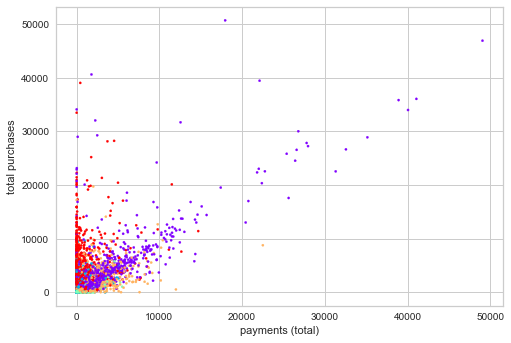

In [23]:
import matplotlib.pyplot as plt

plt.scatter(data['PURCHASES'],data['PAYMENTS'], c=labels, s=5, cmap='rainbow')
plt.xlabel('payments (total)')
plt.ylabel('total purchases')
plt.show()

podemos ver que neste caso, por exemplo, que o cluster vermelho pode ser representado como o de clientes que usam o limite (total de compras) do cartão de crédito, entretanto não pagam a fatura integralmente. Isso pode ser constatado, pois o o cluster vermlho tem um valor de limite de crédito alto e um valor de pagamento da fatura baixo.

No caso do cluster marcado pela cor roxa, podemos ver que o cluster roxo pode ser representado como o de clientes que pagam a fatura integralmente ou quase. Isso pode ser constatado, pois o o cluster roxo cresce de forma proporcional ao valor de pagamento da fatura.

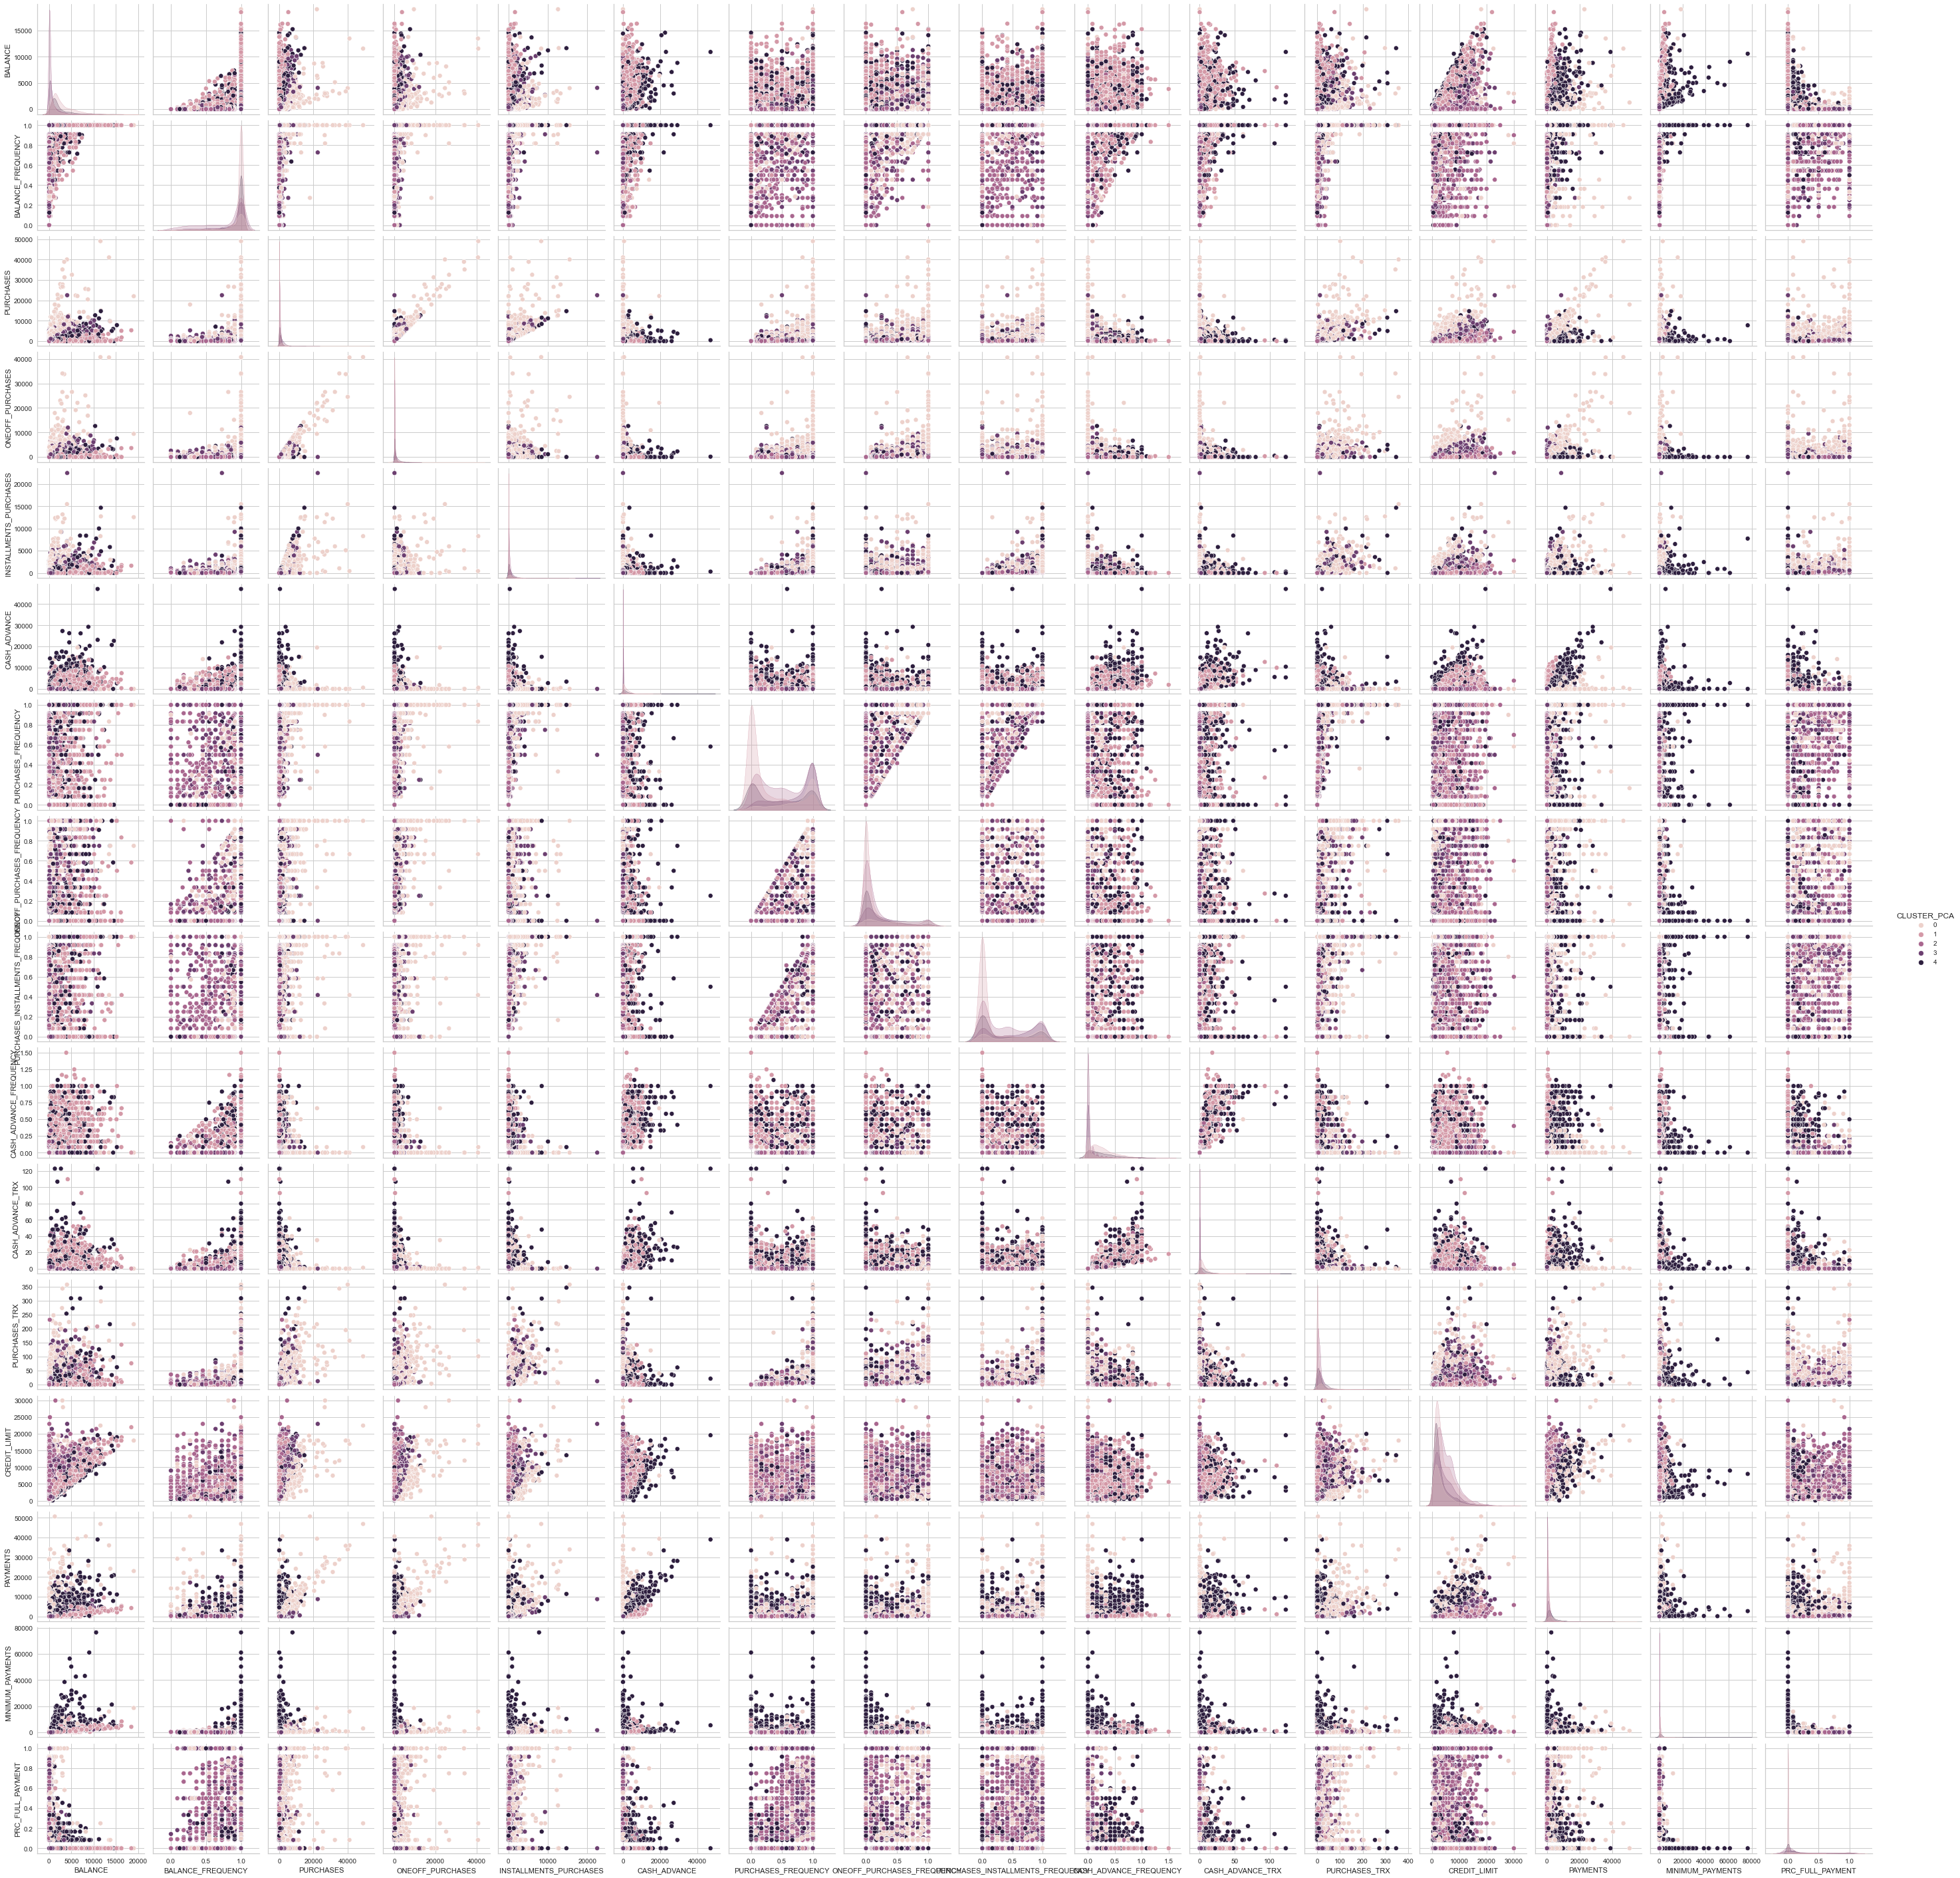

In [24]:
import seaborn as sns
sns.pairplot(data[0:],hue='CLUSTER_PCA')

# Descrevendo os atributos

In [26]:
data.groupby(by='CLUSTER_PCA').describe()

BALANCE                                                   \
              count         mean          std       min          25%   
CLUSTER_PCA                                                            
0             910.0  1020.543125  1621.760399  0.000000   200.662109   
1            2521.0  2969.377425  2465.030187  1.691842  1210.309338   
2            2601.0   489.810590   980.246414  0.000000    19.548437   
3            1499.0   844.234900  1340.812021  0.000000    94.456095   
4            1419.0  2148.026438  2119.429354  0.000000   917.980038   

                                                   BALANCE_FREQUENCY  \
                     50%          75%          max             count   
CLUSTER_PCA                                                            
0             491.037695  1109.489476  19043.13856             910.0   
1            2113.287399  4153.477506  18495.55855            2521.0   
2              69.795639   418.937604  10598.46777            2601.0   
3             317.657562   976.547462  11278.95243            1499.0   
4            1389.085585  2586.514077  15244.74865            1419.0   

                                                                   PURCHASES  \
                 mean       std       min       25%  50%  75%  max     count   
CLUSTER_PCA                                                                    
0            0.883650  0.229364  0.000000  0.909091  1.0  1.0  1.0     910.0   
1            0.952745  0.143188  0.090909  1.000000  1.0  1.0  1.0    2521.0   
2            0.766050  0.307939  0.000000  0.545455  1.0  1.0  1.0    2601.0   
3            0.872202  0.229348  0.000000  0.818182  1.0  1.0  1.0    1499.0   
4            0.948312  0.129131  0.000000  1.000000  1.0  1.0  1.0    1419.0   

                                                                           \
                    mean          std  min        25%       50%       75%   
CLUSTER_PCA                                                                 
0            3756.330418  4991.732435  0.0  1169.7975  2242.065  4438.130   
1             261.763360   556.784905  0.0     0.0000     0.000   270.020   
2             499.733276   606.882530  0.0   104.0000   290.000   669.190   
3            1700.752455  1704.191709  0.0   529.8500  1170.480  2394.885   
4             740.861853  1285.968350  0.0     0.0000   360.000   890.980   

                      ONEOFF_PURCHASES                                 \
                  max            count         mean          std  min   
CLUSTER_PCA                                                             
0            49039.57            910.0  2508.081099  4172.907006  0.0   
1             5288.28           2521.0   158.111015   400.480594  0.0   
2             5491.79           2601.0   249.130023   448.731667  0.0   
3            22500.00           1499.0   972.150847  1296.482768  0.0   
4            14686.10           1419.0   363.721980   827.269121  0.0   

                                                   INSTALLMENTS_PURCHASES  \
                 25%      50%        75%       max                  count   
CLUSTER_PCA                                                                 
0            308.385  1266.46  2945.2425  40761.25                  910.0   
1              0.000     0.00   112.5600   4000.00                 2521.0   
2              0.000     0.00   318.9100   3809.71                 2601.0   
3              0.000   507.32  1435.9650  11994.71                 1499.0   
4              0.000     0.00   388.3900  12650.00                 1419.0   

                                                                       \
                    mean          std  min      25%     50%       75%   
CLUSTER_PCA                                                             
0            1248.932835  1815.132066  0.0  87.5475  723.21  1606.125   
1             103.708869   274.445687  0.0   0.0000    0.00    56.000   
2             250.919912   361.45

In [54]:
normalizer = Normalizer()
normalized_data = normalizer.fit_transform(data)
kmeans = KMeans(n_clusters=5, verbose=False, random_state=seed, n_init=10, max_iter=300)
kmeans.fit_predict(normalized_data)
centroids = kmeans.cluster_centers_

Agora, iremos analisar a variancia dos atributos para cada cluster. o mais importante será encontrar o atributo que mais se destaca em cada cluster.

In [55]:
max = len(centroids[0])
for i in range(max):
    # estamos pegando o valor de cada atributo de cada cluster e calculando a variância
    print(data.columns.values[i],"{:.4f}".format(centroids[:,i].var()))

BALANCE 0.0224
BALANCE_FREQUENCY 0.0000
PURCHASES 0.0196
ONEOFF_PURCHASES 0.0076
INSTALLMENTS_PURCHASES 0.0036
CASH_ADVANCE 0.0225
PURCHASES_FREQUENCY 0.0000
ONEOFF_PURCHASES_FREQUENCY 0.0000
PURCHASES_INSTALLMENTS_FREQUENCY 0.0000
CASH_ADVANCE_FREQUENCY 0.0000
CASH_ADVANCE_TRX 0.0000
PURCHASES_TRX 0.0000
CREDIT_LIMIT 0.0360
PAYMENTS 0.0280
MINIMUM_PAYMENTS 0.0543
PRC_FULL_PAYMENT 0.0000
CLUSTER_PCA 0.0000


- BALANCE 0.0224 (Saldo)
- PURCHASES 0.0196 (Valor total de compras)
- CASH_ADVANCE 0.0225 (Valor de saques em dinheiro)
- CREDIT_LIMIT 0.0360 (Valor do limite de crédito)
- PAYMENTS 0.0280 (Valor total de pagamentos)

In [61]:
normalized_data = pd.DataFrame(normalized_data, columns=data.columns)
normalized_data['CLUSTER_PCA'] = data['CLUSTER_PCA']

In [88]:
description = normalized_data.groupby(by='CLUSTER_PCA')[['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']]

In [89]:
n_clients = description.size()
description = description.mean()
description['N_CLIENTS'] = n_clients

In [90]:
description

BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT  PAYMENTS  \
CLUSTER_PCA                                                              
0            0.127945   0.446839      0.040720      0.470507  0.531977   
1            0.487668   0.040160      0.281488      0.720090  0.165482   
2            0.072206   0.092265      0.022002      0.962952  0.114605   
3            0.127338   0.295101      0.025978      0.804328  0.310652   
4            0.333278   0.124082      0.281592      0.495591  0.453626   

             N_CLIENTS  
CLUSTER_PCA             
0                  910  
1                 2521  
2                 2601  
3                 1499  
4                 1419

agora temos grupos de clientes que se diferenciam em relação ao saldo, valor total de compras, valor de saques em dinheiro, valor do limite de crédito e valor total de pagamentos. Também foi adicionada uma coluna com o numero de clientes em cada cluster.

# Interpretação dos clusters

- CLUSTER 0: Clientes que mais gastam em compras e pagam a fatura integralmente ou quase integralmente. Melhores pagadores.
- CLUSTER 1: Clientes sacam muito, mas não compram muito e não pagam muito. Piores pagadores.
- CLUSTER 2: Clientes que tem limite alto, porém tem um saldo baixo e compram pouco. Bons pagadores.
- CLUSTER 3: Clientes com um bom limite de credito e que gastam moderadamente. Pagam às vezes.
- CLUSTER 4: Clientes que mais sacam dinheiro e têm limite de credito baixo. Maus pagadores.

CONCLUSAO: Os clusters 1 e 4 são os piores pagadores, enquanto os clusters 0 e 2 são os melhores pagadores, sendo o cluster 3 um pagador intermediário, nem Bom nem Mau. 
- O cluster 0 tem a menor quantidade de clientes
- O cluster 2 tem a maior quantidade de clientes
- O cluster 1 está em segundo lugar em quantidade de clientes

In [100]:
data.groupby(by='CLUSTER_PCA')['PRC_FULL_PAYMENT'].describe()
# esta variável mostra o quanto o cliente paga da fatura

count      mean       std  min  25%       50%       75%  max
CLUSTER_PCA                                                               
0             910.0  0.329064  0.376957  0.0  0.0  0.133929  0.666667  1.0
1            2521.0  0.003726  0.030502  0.0  0.0  0.000000  0.000000  0.6
2            2601.0  0.229963  0.337530  0.0  0.0  0.000000  0.400000  1.0
3            1499.0  0.259429  0.356032  0.0  0.0  0.083333  0.500000  1.0
4            1419.0  0.056298  0.112671  0.0  0.0  0.000000  0.083333  1.0

# Aplicabilidade usando teste A/B

- O teste A/B é um teste estatístico que tem como objetivo comparar duas versões de um mesmo produto, serviço ou página web, para saber qual delas é melhor.

- Para fazer o teste A/B, vamos tomar como exemplo o CLUSTER 0. iremos dividir o cluster 0 em dois grupos, um grupo A e um grupo B. O grupo A será o grupo de controle e o grupo B será o grupo de teste. O grupo A será o grupo que não receberá nenhuma oferta de investimento e o grupo B será o grupo que receberá a oferta de investimento.

- O objetivo do teste A/B é verificar se o grupo B, que recebeu a oferta de investimento, tem um melhor desempenho em relação ao grupo A, que não recebeu a oferta de investimento.

- Caso o grupo A tenha um melhor ou equivalente desempenho em relação ao grupo B, então a oferta de investimento não é necessária para o grupo A, pois o grupo A já tem um bom desempenho sem a estratégia determinada.

# Escopo do projeto

- O objetivo do projeto é criar um modelo de machine learning que seja capaz de prever qual perfil de cliente é mais propenso a pagar a fatura integralmente ou quase integralmente, ou seja, qual perfil de cliente é mais propenso a ser um bom pagador.

- Este projeto pode ser aplicado em empresas que oferecem cartões de crédito, pois assim, a empresa poderá oferecer um cartão de crédito para o cliente que mais se encaixa no perfil de bom pagador, assim como aplicar estratégias para melhorar o perfil de pagamentos dos clientes que mais se encaixam no perfil de mau pagador.

- Pode-se também aplicar estratégias de ofertas de investimentos para os clientes bons pagadores

- É possivel, a patir do modelo de machine learning, criar um sistema de recomendação de cartões de crédito para os clientes, de acordo com o perfil de cada um, com limites especificos para cada tipo de cliente.

- Estes sao só alguns exemplos de como o modelo de machine learning pode ser aplicado em empresas que oferecem cartões de crédito e serviços financeiros no geral.